## Imports

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Normalization

## Load Data

In [202]:
high_altitude = pd.read_csv("./data/measurements-high-altitude.csv")
low_altitude = pd.read_csv("./data/measurements-low-altitude.csv")

## Data cleanup

In [203]:
list(high_altitude)

['hour',
 ' minute',
 ' second',
 ' azimuth angle (relative to west=0)/degree',
 ' elevation angle/degree',
 ' power/mW']

In [204]:
high_altitude.rename(columns={" power/mW" : "power", " azimuth angle (relative to west=0)/degree" : "azimuth", " elevation angle/degree" : "elevation"}, inplace = True)
high_altitude.columns = high_altitude.columns.str.replace(" ", "")

low_altitude.rename(columns={" power/mW" : "power", " azimuth angle (relative to west=0)/degree" : "azimuth", " elevation angle/degree" : "elevation"}, inplace = True)
low_altitude.columns = low_altitude.columns.str.replace(" ", "")

In [205]:
high_altitude.head()

,hour,minute,second,azimuth,elevation,power
0,9,45,5,0,0,32
1,9,45,9,0,15,879
2,9,45,12,0,30,34
3,9,45,15,0,45,35
4,9,45,18,0,60,51


In [206]:
low_altitude.head()

,hour,minute,second,azimuth,elevation,power
0,10,38,3,0,0,56
1,10,38,7,0,15,57
2,10,38,10,0,30,59
3,10,38,14,0,45,57
4,10,38,16,0,60,83


In [207]:
high_altitude.describe()

,hour,minute,second,azimuth,elevation,power
count,2469.000000,2469.000000,2469.000000,2469.000000,2469.000000,2469.000000
mean,11.735925,29.474281,29.589307,89.467801,45.006075,231.443904
std,1.498760,17.265160,17.289971,57.050976,30.037962,175.365305
min,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,15.000000,15.000000,36.000000,15.000000,129.000000
50%,12.000000,30.000000,30.000000,90.000000,45.000000,217.000000
75%,13.000000,45.000000,45.000000,144.000000,75.000000,333.000000
max,14.000000,59.000000,59.000000,180.000000,90.000000,4168.000000


In [208]:
high_altitude.loc[high_altitude.power.idxmax(),:]

hour            9
minute         45
second         38
azimuth        18
elevation      45
power        4168
Name: 10, dtype: int64

In [209]:
low_altitude.describe()

,hour,minute,second,azimuth,elevation,power
count,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000
mean,11.880294,30.643139,29.224732,90.000000,45.000000,279.383399
std,1.090955,18.001482,17.335092,56.937075,30.008473,82.632597
min,10.000000,0.000000,0.000000,0.000000,0.000000,41.000000
25%,11.000000,14.000000,14.000000,36.000000,15.000000,225.000000
50%,12.000000,32.000000,29.000000,90.000000,45.000000,302.000000
75%,13.000000,47.000000,44.000000,144.000000,75.000000,352.000000
max,14.000000,59.000000,59.000000,180.000000,90.000000,378.000000


### Convert time in seconds

In [210]:
h, m, s = high_altitude.hour.tolist(), high_altitude.minute.tolist(), high_altitude.second.tolist()
seconds = []
for i in range(len(s)):
  seconds.append(int(datetime.timedelta(hours=int(h[i]),minutes=int(m[i]),seconds=int(s[i])).total_seconds()))
  

In [211]:
def get_seconds(h, m, s):
  s_vec = []
  for i in range(len(s)):
    s_vec.append(h[i]*3600 + m[i]*60 + s[i])
  return s_vec

In [212]:
h, m, s = high_altitude.hour.tolist(), high_altitude.minute.tolist(), high_altitude.second.tolist()
seconds = get_seconds(h,m,s)
high_altitude.drop(columns=["hour", "minute", "second"], inplace=True)
high_altitude["seconds"] = seconds

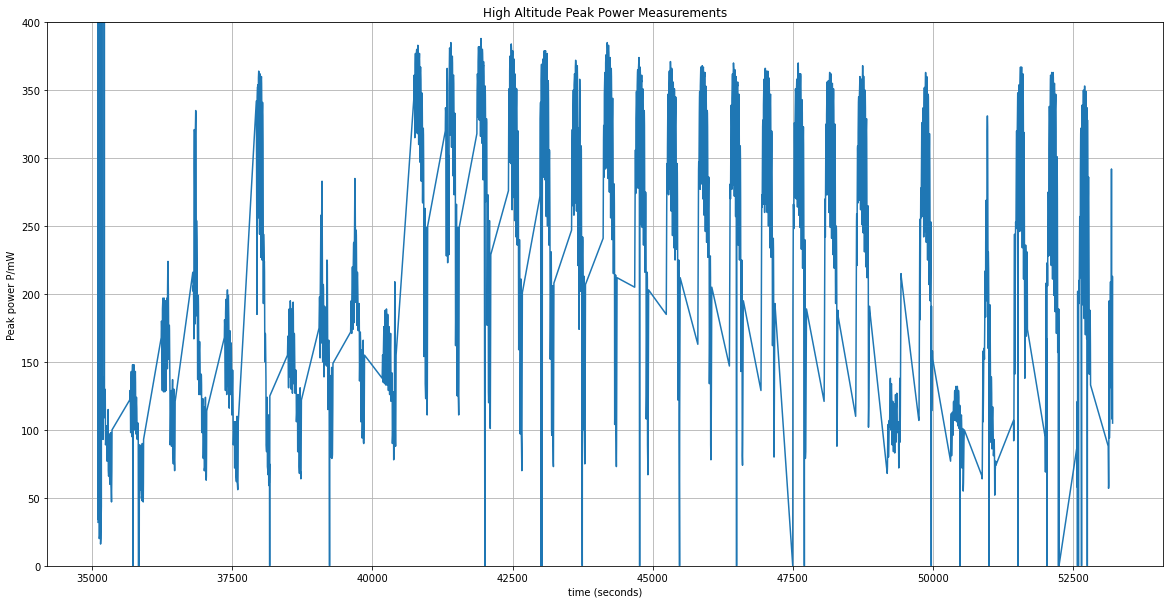

In [213]:
plt.figure(figsize=(20,10))
plt.plot(seconds, high_altitude.power)
plt.ylim(high_altitude.power.min(), 400)
plt.title("High Altitude Peak Power Measurements")
plt.xlabel("time (seconds)")
plt.ylabel("Peak power P/mW")
plt.grid()

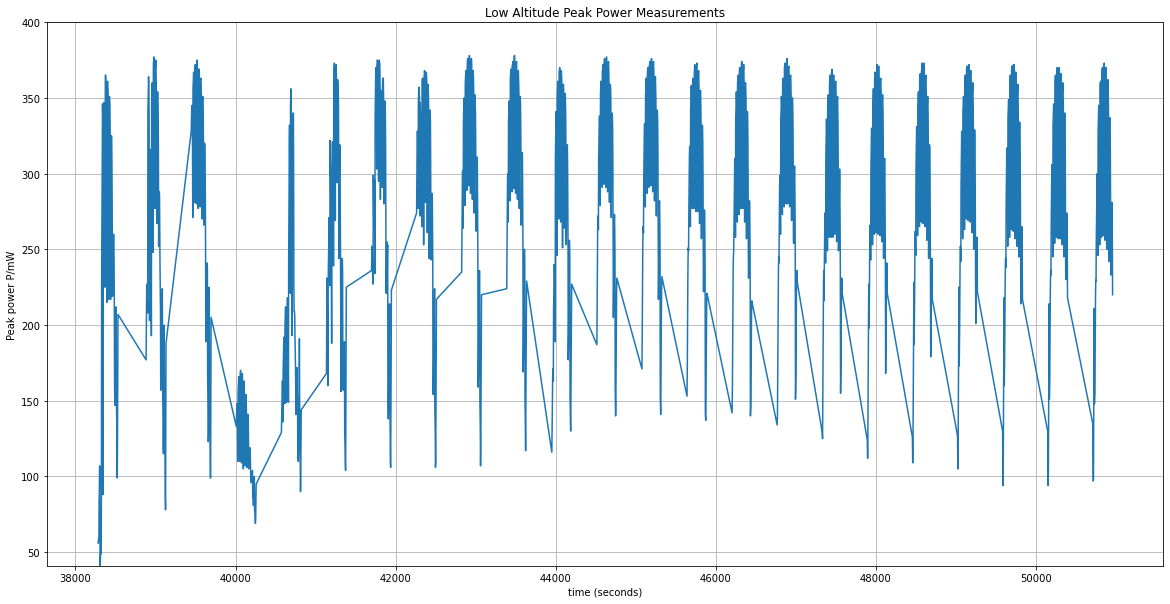

In [214]:
h, m, s = low_altitude.hour.tolist(), low_altitude.minute.tolist(), low_altitude.second.tolist()

seconds = get_seconds(h,m,s)
low_altitude.drop(columns=["hour", "minute", "second"], inplace=True)
low_altitude["seconds"] = seconds


plt.figure(figsize=(20,10))
plt.plot(seconds, low_altitude.power)
plt.ylim(low_altitude.power.min(), 400)
plt.title("Low Altitude Peak Power Measurements")
plt.xlabel("time (seconds)")
plt.ylabel("Peak power P/mW")
plt.grid()

In [215]:
high_altitude.head()

,azimuth,elevation,power,seconds
0,0,0,32,35105
1,0,15,879,35109
2,0,30,34,35112
3,0,45,35,35115
4,0,60,51,35118


In [216]:
X_low_train = low_altitude.sample(frac=0.8, random_state=2)
X_low_test = low_altitude.drop(X_low_train.index)


In [ ]:
y_low_train = X_low_train.pop("power")
y_low_test = X_low_test.pop("power")

In [218]:
X_low_train.head()

,azimuth,elevation,seconds
540,0,15,42266
1502,90,60,49146
756,162,0,43593
978,126,75,45254
1663,108,60,50295


In [219]:
y_low_train.head()

540     300
1502    357
756     169
978     329
1663    356
Name: power, dtype: int64

In [220]:
X_low_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
azimuth,1417.0,88.818631,56.954948,0.0,36.0,90.0,144.0,180.0
elevation,1417.0,45.719831,30.065439,0.0,15.0,45.0,75.0,90.0
seconds,1417.0,44603.666902,3750.223171,38283.0,41303.0,44616.0,47934.0,50956.0


In [221]:
normalizer = Normalization(axis=-1)
normalizer.adapt(np.array(X_low_train))

print(normalizer.mean.numpy())

2022-06-23 12:14:56.628908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-23 12:14:56.647524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[   88.81864     45.719826 44603.668   ]]


In [222]:
first_sample = np.array(X_low_train[:1])

with np.printoptions(precision=2, suppress=True):
  print(np.sort(first_sample))
  print(np.sort(normalizer(first_sample).numpy()))
  


[[    0    15 42266]]
[[-1.56 -1.02 -0.62]]


## Regression using MLP

In [225]:
reg = Sequential([
  normalizer,
  Dense(units=256, activation='relu'),
  Dropout(0.3),
  Dense(units=128, activation='relu'),
  Dense(units=1)
])

reg.predict(X_low_train[:10])


2022-06-23 12:15:45.892300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[ 0.02395447],
       [ 0.01452025],
       [ 0.1511569 ],
       [ 0.03989986],
       [ 0.02857662],
       [ 0.01334161],
       [ 0.06659061],
       [-0.03160938],
       [ 0.07790696],
       [ 0.05425984]], dtype=float32)

In [226]:
reg.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 3)                7         
 ion)                                                            
                                                                 
 dense_12 (Dense)            (None, 256)               1024      
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 34,056
Trainable params: 34,049
Non-trainable params: 7
__________________________________________________

In [227]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

In [228]:
reg.compile(optimizer="adam", loss="mean_squared_error")

In [229]:
history = reg.fit(X_low_train, y_low_train, epochs=300, validation_split=0.2)

Epoch 1/300


2022-06-23 12:15:53.008321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 1s 18ms/step - loss: 83456.7344 - val_loss: 79444.6406
Epoch 2/300
21/36 [================>.............] - ETA: 0s - loss: 77413.7344

2022-06-23 12:15:53.907926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 0s 6ms/step - loss: 73747.8672 - val_loss: 62730.2305
Epoch 3/300
36/36 [==============================] - 0s 6ms/step - loss: 48369.0352 - val_loss: 30965.6973
Epoch 4/300
36/36 [==============================] - 0s 6ms/step - loss: 19373.0410 - val_loss: 11358.5557
Epoch 5/300
36/36 [==============================] - 0s 6ms/step - loss: 10647.2363 - val_loss: 9700.8535
Epoch 6/300
36/36 [==============================] - 0s 6ms/step - loss: 10032.8037 - val_loss: 9196.8838
Epoch 7/300
36/36 [==============================] - 0s 9ms/step - loss: 9574.2148 - val_loss: 8780.6094
Epoch 8/300
36/36 [==============================] - 0s 8ms/step - loss: 8986.3174 - val_loss: 8334.2256
Epoch 9/300
36/36 [==============================] - 0s 9ms/step - loss: 8614.8145 - val_loss: 7936.5552
Epoch 10/300
36/36 [==============================] - 0s 7ms/step - loss: 8332.5283 - val_loss: 7639.9082
Epoch 11/300
36/36 [==============================] - 0s 7

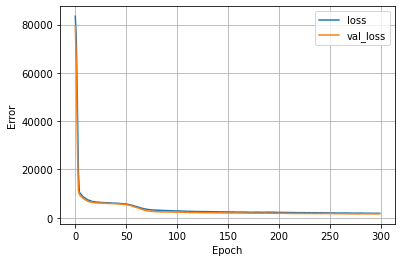

In [230]:
plot_loss(history)

In [231]:
results = reg.evaluate(X_low_test, y_low_test, )

12/12 [==============================] - 0s 14ms/step - loss: 1727.8088
